# Introduction
This notebook compares four time-series models and a hybrid performance on the testing data to predict total daily energy demand in Saskatchewan. These models utilized include Fb Prophet, LightGBM (Light Gradient Boosting Machine), SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors), LSTM (Long Short-Term Memory), Hybrid Prophet-LGBM, and Hybrid Prophet-LSTM. 

Each model has been trained and validated on the learning dataset using cross-validation, and their performances are evaluated using metrics, such as Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), Median Absolute Percentage Error (MdAPE), and R-squared and the results are stored for each fold in the cross-validation. Finally, the performance of all models on the testing dataset are compared, conclusions are drawn based on the evaluation metrics, and potential improvements for future work are considered in this notebook.

This notebook focused on the reviewing the performance of each models on the testing dataset to select the best model for future prediction.

# Load Data
Forecasting daily natural gas consumption accurately is difficult because it is affected by various factors. The dataset is the historical daily natural gas demand in energy unit (TJ/d) and the weather data in Saskatchewan from November 1, 2013 to October 31, 2023. This dataset has be preprocessed and explored in the "cleaning_EDA.ipynb" notebook and is fit for model development. 

In [2]:
# Importing the necessary libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Import the merged dataset (Natural Gas demand and Weather factors)
merged_df = pd.read_csv('../data/merged_data.csv')
merged_df.head()

,DATE,NG_DEMAND,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01,617,44.400000,80.333333,14.833333,0.0,0.140000,-2.933333,3.166667,9.206667,28.066667,40.600000
1,2013-11-02,630,34.133333,73.066667,16.293333,0.0,0.226667,-5.866667,1.706667,9.266667,8.400000,25.400000
2,2013-11-03,688,60.133333,81.600000,16.726667,0.0,5.806667,-2.166667,1.273333,4.706667,24.400000,55.000000
3,2013-11-04,815,66.466667,79.133333,23.540000,0.0,0.900000,-9.106667,-5.540000,-1.906667,31.466667,56.933333
4,2013-11-05,789,53.000000,71.666667,27.820000,0.0,0.040000,-14.966667,-9.820000,-4.633333,15.800000,21.600000


# Data Preparation for Modelling 

For this step, we are preparing the series for Cross-validation evaluation and the Train-test Split method.

- Train-test Split method: This method involves splitting the dataset into a learning set (training and validation data) and a testing set. The model is trained and validated on the training set using the cross-validation explain below, and then tested on the testing set to evaluate its performance.

- 
Cross-Validation: Cross-validation is a technique used to evaluate the performance of a machine learning model on unseen data. It involves dividing the available data into multiple folds or subsets, using one of these folds as a validation set, and training the model on the remaining folds

In [4]:
# Split the data into learning set from 2013-11-01 to 2022-04-31, and using 2022-05-01 to 2023-10-31 as testing set
learning_data_df = merged_df[merged_df['DATE'] < '2022-05-01'] # train/validation set
testing_data_df = merged_df[merged_df['DATE'] >= '2022-05-01'] # testing set

# Print the shape of the train-test split
print(learning_data_df.shape)
print(testing_data_df.shape)

(3103, 12)
(549, 12)


# Model Building
In this project, the recommended models to be utilized are Prophet, LightGBM, SARIMAX, LSTM, Hybrid Prophet-LGBM, and Hybrid Prophet-LSTM.

## 1. Baseline Model
In every modeling process, there needs to be a baseline model whose results can be used to assess our primary ones. In our case, we chose to use a Linear Regression model because of its simplicity and efficiency.

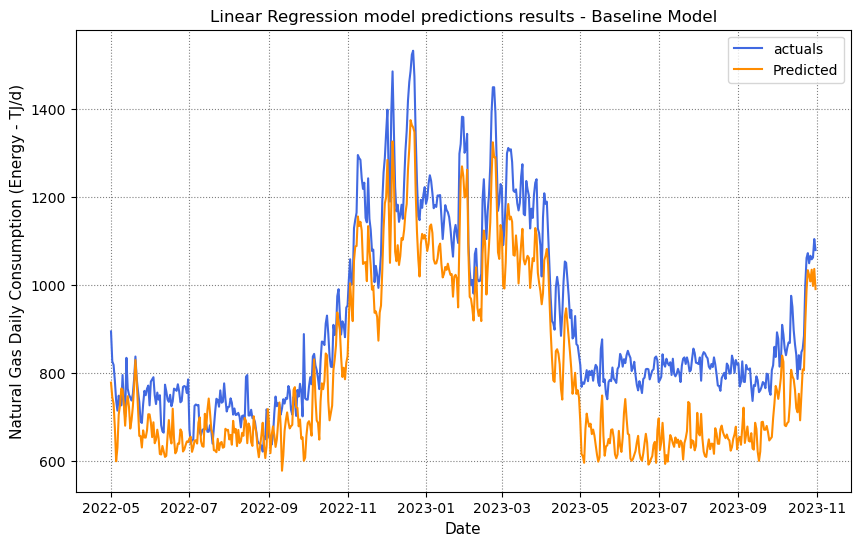

Mean Squared Error: 14638.16
Mean Absolute Error: 109.18
Root Mean Squared Error: 120.99
R-squared: 0.65
Mean Absolute Percentage Error: 12.21%
Median Absolute Percentage Error: 11.19%


In [8]:
# Load the saved Prophet model
with open('../models/baseline_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
    
# Load the testing dataset 
testing_df = testing_data_df.copy()
X_test = testing_df.drop(['DATE', 'NG_DEMAND'], axis=1)
y_test = testing_df['NG_DEMAND']

# Predict on the test set
predictions = loaded_model.predict(X_test)

# Function to calculate MAPE and MdAPE
def calculate_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    return mape, mdape
    
# Calculate the mean squared error of the predictions
test_mse_bm = mean_squared_error(y_test, predictions)
test_mae_bm = mean_absolute_error(y_test, predictions)
test_rmse_bm = np.sqrt(test_mse_bm)
test_r2_bm = r2_score(y_test, predictions)
test_mape_bm, test_mdape_bm = calculate_percentage_error(y_test, predictions)

# Convert the Date to datetime
testing_df['DATE'] = pd.to_datetime(testing_df['DATE'])

# Plot actual vs. forecast values
plt.figure(figsize=(10, 6))
plt.plot(testing_df['DATE'], y_test, label='actuals', color='royalblue')
plt.plot(testing_df['DATE'], predictions, label='Predicted', color='darkorange')
plt.title('Linear Regression model predictions results - Baseline Model', fontsize=12)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Natural Gas Daily Consumption (Energy - TJ/d)', fontsize=11)
plt.legend()
plt.grid(linestyle=":", color='grey')
plt.show()

# Create a dataframe that contains testing_set_df['DATE'], testing_set_df['NG_DEMAND'], and y_pred
baseline_results_df = testing_df[['DATE', 'NG_DEMAND']].copy()
baseline_results_df['Predicted_NG_DEMAND'] = predictions

# Print the predictions performance metrics
print(f'Mean Squared Error: {test_mse_bm:.2f}')
print(f'Mean Absolute Error: {test_mae_bm:.2f}')
print(f'Root Mean Squared Error: {test_rmse_bm:.2f}')
print(f'R-squared: {test_r2_bm:.2f}')
print(f'Mean Absolute Percentage Error: {test_mape_bm:.2f}%')
print(f'Median Absolute Percentage Error: {test_mdape_bm:.2f}%')

In [9]:
baseline_results_df.to_csv('../data/baseline_prediction.csv', index=False)
(baseline_results_df)

,DATE,NG_DEMAND,Predicted_NG_DEMAND
3103,2022-05-01,894,777.671334
3104,2022-05-02,826,744.874738
3105,2022-05-03,818,729.857658
3106,2022-05-04,782,675.045716
3107,2022-05-05,737,599.001292
...,...,...,...
3647,2023-10-27,1066,1007.629647
3648,2023-10-28,1058,1034.261140
3649,2023-10-29,1062,997.352522
3650,2023-10-30,1104,1036.125898


In [10]:
baseline_predictions_df = pd.read_csv('../data/baseline_prediction.csv')
baseline_predictions_df.head()

,DATE,NG_DEMAND,Predicted_NG_DEMAND
0,2022-05-01,894,777.671334
1,2022-05-02,826,744.874738
2,2022-05-03,818,729.857658
3,2022-05-04,782,675.045716
4,2022-05-05,737,599.001292


In [11]:
# Define the metrics for the predicted model
baseline_prediction_metrics = [test_mse_bm, test_rmse_bm, test_mape_bm, test_mae_bm, test_mdape_bm, test_r2_bm]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_baseline_pred = pd.DataFrame({'Baseline Model Prediction': baseline_prediction_metrics}, index=labels)

# Transpose the DataFrame
df_baseline_pred = df_baseline_pred.transpose()

# Save the DataFrame to a CSV file
df_baseline_pred.to_csv('../data/baseline_predictions_metrics.csv', index=False)
df_baseline_pred.head()

,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
Baseline Model Prediction,14638.16179,120.988271,12.206542,109.184173,11.187602,0.652135


# Model Evaluations

## 1. Performance Metrics

In [12]:
# Read the CSV file
baseline_predictions_metrics_df = pd.read_csv('../data/baseline_predictions_metrics.csv')

# Add a new column 'Model' at the beginning of the DataFrame with default value None
baseline_predictions_metrics_df.insert(0, 'Model', 'Baseline')
baseline_predictions_metrics_df.head()

,Model,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
0,Baseline,14638.16179,120.988271,12.206542,109.184173,11.187602,0.652135


**Prophet Model**

In [13]:
# Read the CSV file
prophet_predictions_metrics_df = pd.read_csv('../data/prophet_predictions_metrics.csv')

# Add a new column 'Model' at the beginning of the DataFrame with default value None
prophet_predictions_metrics_df.insert(0, 'Model', 'Prophet')
prophet_predictions_metrics_df.head()

,Model,MSE,RMSE,MAE,MAPE,MDAPE,R-squared
0,Prophet,4337.651102,65.860847,53.100838,NaN,NaN,0.896919


In [14]:
prophet_predictions_df = pd.read_csv('../data/prophet_prediction.csv')
prophet_predictions_df.head()


,ds,y,yhat
0,2022-05-01,894,843.235901
1,2022-05-02,826,822.467927
2,2022-05-03,818,795.454454
3,2022-05-04,782,759.290193
4,2022-05-05,737,696.449118


In [15]:
prophet_predictions_df = prophet_predictions_df.rename(columns={'ds': 'DATE', 'y': 'NG_DEMAND', 'yhat': 'Predicted_NG_DEMAND'})
print(prophet_predictions_df)

           DATE  NG_DEMAND  Predicted_NG_DEMAND
0    2022-05-01        894           843.235901
1    2022-05-02        826           822.467927
2    2022-05-03        818           795.454454
3    2022-05-04        782           759.290193
4    2022-05-05        737           696.449118
..          ...        ...                  ...
544  2023-10-27       1066          1199.852283
545  2023-10-28       1058          1221.488383
546  2023-10-29       1062          1189.455045
547  2023-10-30       1104          1248.153253
548  2023-10-31       1079          1194.691063

[549 rows x 3 columns]


**LSTM Model**

In [16]:
# Read the CSV file
lstm_predictions_metrics_df = pd.read_csv('../data/lstm_predictions_metrics.csv')

# Add a new column 'Model' at the beginning of the DataFrame with default value None
lstm_predictions_metrics_df.insert(0, 'Model', 'LSTM')
lstm_predictions_metrics_df.head()

,Model,MSE,MAE,RMSE,MAPE,MDAPE,R-squared
0,LSTM,1855.090745,31.359789,43.070764,3.414569,2.515046,0.956021


In [17]:
lstm_predictions_df = pd.read_csv('../data/lstm_prediction.csv')
print(lstm_predictions_df)

           DATE  NG_DEMAND  Predicted_NG_DEMAND
0    2022-05-03      826.0            894.27350
1    2022-05-04      818.0            830.23740
2    2022-05-05      782.0            820.02370
3    2022-05-06      737.0            780.22390
4    2022-05-07      714.0            738.19855
..          ...        ...                  ...
542  2023-10-27     1049.0           1084.21030
543  2023-10-28     1066.0           1051.96410
544  2023-10-29     1058.0           1083.61980
545  2023-10-30     1062.0           1063.82230
546  2023-10-31     1104.0           1069.22740

[547 rows x 3 columns]


**LightGBM Model**

In [27]:
# Read the CSV file
lightgbm_predictions_metrics_df = pd.read_csv('../data/lightgbm_predictions_metrics.csv')

# Add a new column 'Model' at the beginning of the DataFrame with default value None
lightgbm_predictions_metrics_df.insert(0, 'Model', 'LightGBM')
lightgbm_predictions_metrics_df.head()

,Model,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
0,LightGBM,14269.283544,119.454106,12.132852,108.222045,11.483491,0.660901


In [28]:
lightgbm_predictions_df = pd.read_csv('../data/lightgbm_prediction.csv')
lightgbm_predictions_df.head()

,DATE,NG_DEMAND,Predicted_NG_DEMAND
0,2022-05-01,894,726.406121
1,2022-05-02,826,708.367329
2,2022-05-03,818,712.784014
3,2022-05-04,782,677.040199
4,2022-05-05,737,653.258938


**SARIMAX Model**

In [20]:
# Read the CSV file
sarimax_predictions_metrics_df = pd.read_csv('../data/sarimax_predictions_metrics.csv')

# Add a new column 'Model' at the beginning of the DataFrame with default value None
sarimax_predictions_metrics_df.insert(0, 'Model', 'SARIMAX')
sarimax_predictions_metrics_df.head()

,Model,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
0,SARIMAX,4260.0,65.2,6.11,54.0,5.33,0.899


In [21]:
sarimax_predictions_df = pd.read_csv('../data/sarimax_prediction.csv')
print(sarimax_predictions_df)

           DATE  NG_DEMAND  Predicted_NG_DEMAND
0    2022-05-01        894           900.770210
1    2022-05-02        826           841.161946
2    2022-05-03        818           825.648137
3    2022-05-04        782           843.407415
4    2022-05-05        737           748.287475
..          ...        ...                  ...
544  2023-10-27       1066          1074.246828
545  2023-10-28       1058          1080.853424
546  2023-10-29       1062          1075.776091
547  2023-10-30       1104          1107.091532
548  2023-10-31       1079          1058.567320

[549 rows x 3 columns]


**Hybrid LSTM-Prophet**

In [22]:
# Read the CSV file
hybrid_predictions_metrics_df = pd.read_csv('../data/hybrid_predictions_metrics.csv')

# Add a new column 'Model' at the beginning of the DataFrame with default value None
hybrid_predictions_metrics_df.insert(0, 'Model', 'LSTM-Prophet')
hybrid_predictions_metrics_df.head()

,Model,MSE,MAE,RMSE,MAPE,MDAPE,R-squared
0,LSTM-Prophet,653.939033,21.888988,25.572232,2.48612,2.101456,0.984469


In [23]:
hybrid_predictions_df = pd.read_csv('../data/hybrid_prediction.csv')
hybrid_predictions_df.head()

,ds,y,Predicted_y,Optimized_Predicted_y
0,2022-05-01,894,842.833315,867.413042
1,2022-05-02,826,791.773494,808.845179
2,2022-05-03,818,775.120489,795.785330
3,2022-05-04,782,737.149591,758.707437
4,2022-05-05,737,682.761460,708.890626


In [39]:
hybrid_predictions_df = hybrid_predictions_df.rename(columns={'ds': 'DATE', 'y': 'NG_DEMAND', 'Predicted_y': 'Predicted_NG_DEMAND', 'Optimized_Predicted_y': 'Optimized_Predicted_NG_DEMAND'})
print(hybrid_predictions_df)

           DATE  NG_DEMAND  Predicted_NG_DEMAND  Optimized_Predicted_NG_DEMAND
0    2022-05-01        894           842.833315                     867.413042
1    2022-05-02        826           791.773494                     808.845179
2    2022-05-03        818           775.120489                     795.785330
3    2022-05-04        782           737.149591                     758.707437
4    2022-05-05        737           682.761460                     708.890626
..          ...        ...                  ...                            ...
543  2023-10-26       1049          1026.518989                    1039.765647
544  2023-10-27       1066          1031.369747                    1048.596081
545  2023-10-28       1058          1034.691675                    1048.161661
546  2023-10-29       1062          1024.460240                    1042.840397
547  2023-10-30       1104          1071.859865                    1088.154924

[548 rows x 4 columns]


In [29]:
# Append the DataFrames
models_evaluation_df = pd.concat([baseline_predictions_metrics_df, prophet_predictions_metrics_df, lstm_predictions_metrics_df, hybrid_predictions_metrics_df, 
                                  sarimax_predictions_metrics_df, lightgbm_predictions_metrics_df], ignore_index=True)

models_evaluation_df.head(10)

,Model,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
0,Baseline,14638.161790,120.988271,12.206542,109.184173,11.187602,0.652135
1,Prophet,4337.651102,65.860847,NaN,53.100838,NaN,0.896919
2,LSTM,1855.090745,43.070764,3.414569,31.359789,2.515046,0.956021
3,LSTM-Prophet,653.939033,25.572232,2.486120,21.888988,2.101456,0.984469
4,SARIMAX,4260.000000,65.200000,6.110000,54.000000,5.330000,0.899000
5,LightGBM,14269.283544,119.454106,12.132852,108.222045,11.483491,0.660901


In [31]:
metrics_df = models_evaluation_df.copy()
# Set the index to 'Model' for easier plotting
metrics_df.set_index('Model', inplace=True)
metrics_df.head(10)

,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
Model,,,,,,
Baseline,14638.161790,120.988271,12.206542,109.184173,11.187602,0.652135
Prophet,4337.651102,65.860847,NaN,53.100838,NaN,0.896919
LSTM,1855.090745,43.070764,3.414569,31.359789,2.515046,0.956021
LSTM-Prophet,653.939033,25.572232,2.486120,21.888988,2.101456,0.984469
SARIMAX,4260.000000,65.200000,6.110000,54.000000,5.330000,0.899000
LightGBM,14269.283544,119.454106,12.132852,108.222045,11.483491,0.660901


- In summary, the LSTM-Prophet model performed the best according to these metrics, with the lowest error values and the highest R-squared value. 
- The Baseline and LightGBM models had higher error values and lower R-squared values, indicating a poorer fit. 
- The LSTM and Prophet models performed well according to the available metrics, but the Prophet MAPE and MDAPE values were not available for comparison. 
- The SARIMAX model also performed well with an R-squared value of 0.90.

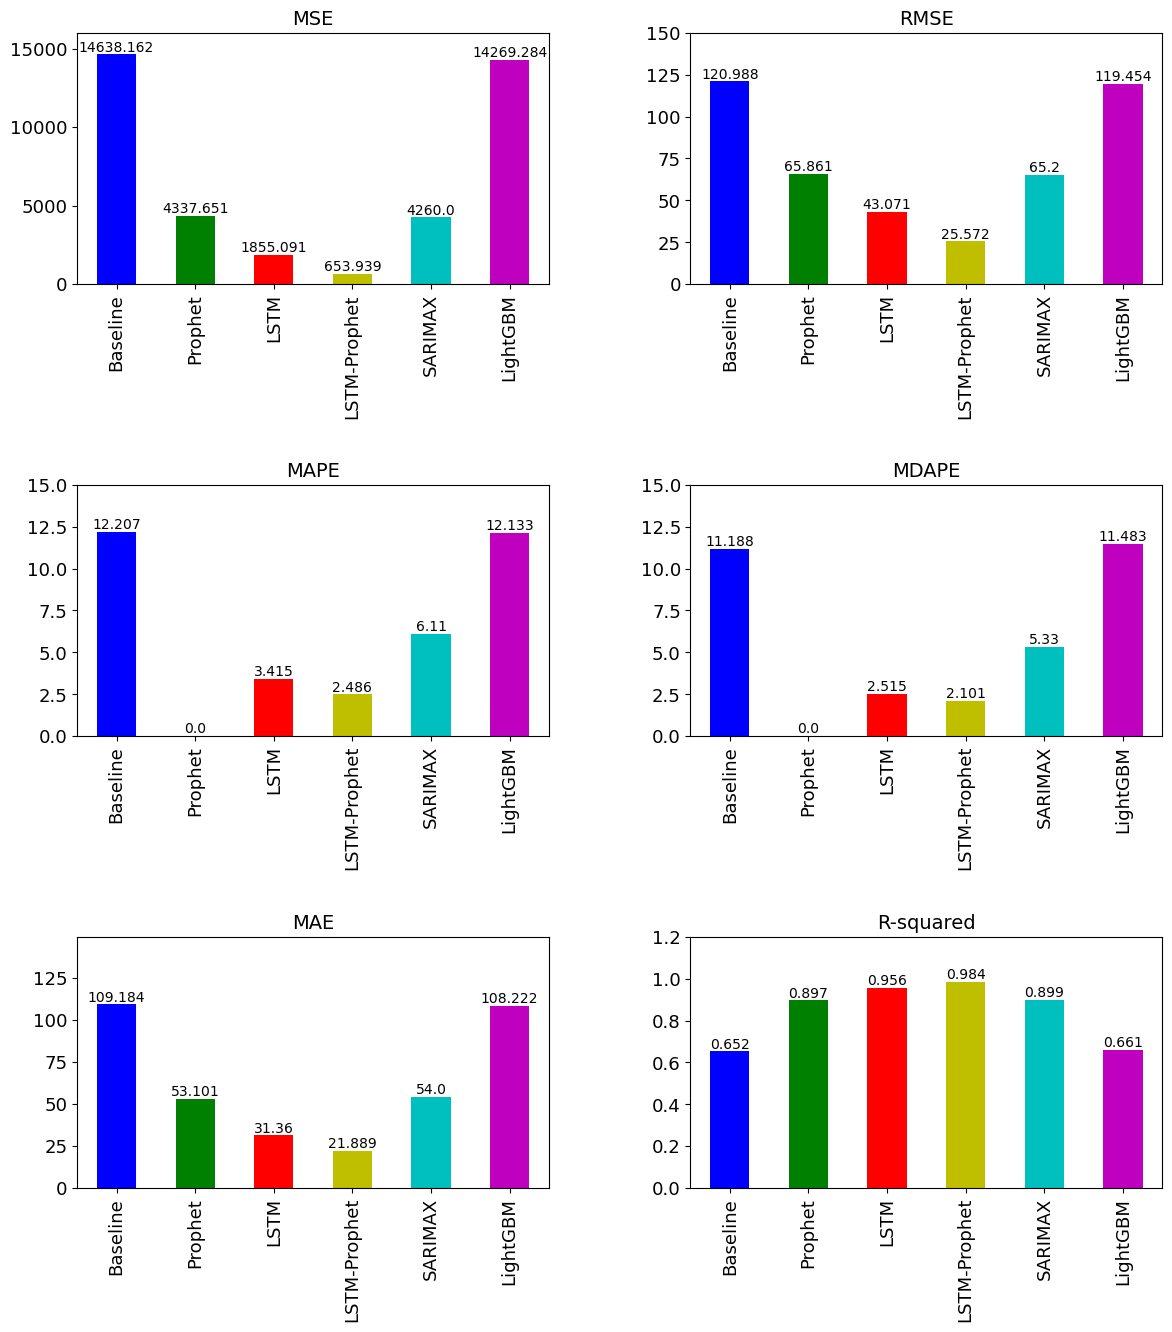

In [45]:
df = models_evaluation_df.copy()

# Replace any NaN values with zero
df.fillna(0, inplace=True)

# Set the index to 'Model' for easier plotting
df.set_index('Model', inplace=True)

# Define the colors for the different models
colors = {'Baseline': 'b', 'Prophet': 'g', 'LSTM': 'r', 'SARIMAX': 'c', 'LightGBM': 'm', 'LSTM-Prophet': 'y'}

# Plot bar charts for the different metrics in two columns
fig, axs = plt.subplots(3, 2, figsize=(14, 15))
axs = axs.ravel()
for i, metric in enumerate(['MSE', 'RMSE', 'MAPE', 'MDAPE', 'MAE', 'R-squared']):
    bars = df[metric].plot(kind='bar', ax=axs[i], color=[colors.get(model, 'k') for model in df.index])
    axs[i].set_title(metric, fontsize=14)
    axs[i].set_ylabel('')
    axs[i].tick_params(axis='both', which='major', labelsize=13)
    axs[i].set_xlabel('')  # Remove x-label
    
    # Set y-axis limit
    if metric == 'MSE':
        axs[i].set_ylim([0, 16000])  # Set y-axis limit for MSE
    elif metric == 'RMSE':
        axs[i].set_ylim([0, 150])  # Set y-axis limit for RMSE
    elif metric == 'R-squared':
        axs[i].set_ylim([0, 1.2])  # Set y-axis limit for R-squared
    elif metric == 'MAPE':
        axs[i].set_ylim([0, 15])  # Set y-axis limit for MAPE
    elif metric == 'MDAPE':
        axs[i].set_ylim([0, 15])  # Set y-axis limit for MDAPE
        
    else:
        axs[i].set_ylim([0, df[metric].max() + 40])  # Set y-axis limit for other metrics
    
    # Add values on the bars
    for bar in bars.patches:
        yval = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width()/2, yval + .00005, round(yval, 3), ha='center', va='bottom')

# Increase space between the plots
plt.subplots_adjust(wspace=0.3, hspace=0.8)

plt.show()

## 2. Comparison of Predicted Demand

In [40]:
models_predictions_df = pd.concat([baseline_predictions_df[['DATE', 'NG_DEMAND', 'Predicted_NG_DEMAND']], 
                                   prophet_predictions_df[['Predicted_NG_DEMAND']], 
                                   lstm_predictions_df[['Predicted_NG_DEMAND']], 
                                   hybrid_predictions_df[['Optimized_Predicted_NG_DEMAND']], 
                                   sarimax_predictions_df[['Predicted_NG_DEMAND']], 
                                   lightgbm_predictions_df[['Predicted_NG_DEMAND']]], 
                                  axis=1)

models_predictions_df.columns = ['DATE', 'NG_DEMAND', 'Baseline', 'Prophet', 'LSTM', 'LSTM-Prophet', 'SARIMAX', 'LightGBM']
(models_predictions_df)

,DATE,NG_DEMAND,Baseline,Prophet,LSTM,LSTM-Prophet,SARIMAX,LightGBM
0,2022-05-01,894,777.671334,843.235901,894.27350,867.413042,900.770210,726.406121
1,2022-05-02,826,744.874738,822.467927,830.23740,808.845179,841.161946,708.367329
2,2022-05-03,818,729.857658,795.454454,820.02370,795.785330,825.648137,712.784014
3,2022-05-04,782,675.045716,759.290193,780.22390,758.707437,843.407415,677.040199
4,2022-05-05,737,599.001292,696.449118,738.19855,708.890626,748.287475,653.258938
...,...,...,...,...,...,...,...,...
544,2023-10-27,1066,1007.629647,1199.852283,1083.61980,1048.596081,1074.246828,1016.684559
545,2023-10-28,1058,1034.261140,1221.488383,1063.82230,1048.161661,1080.853424,1053.172950
546,2023-10-29,1062,997.352522,1189.455045,1069.22740,1042.840397,1075.776091,1004.868241
547,2023-10-30,1104,1036.125898,1248.153253,NaN,1088.154924,1107.091532,1013.934609


In [41]:
models_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          549 non-null    object 
 1   NG_DEMAND     549 non-null    int64  
 2   Baseline      549 non-null    float64
 3   Prophet       549 non-null    float64
 4   LSTM          547 non-null    float64
 5   LSTM-Prophet  548 non-null    float64
 6   SARIMAX       549 non-null    float64
 7   LightGBM      549 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 34.4+ KB


**Plotting top 3 models predictions for this analysis**

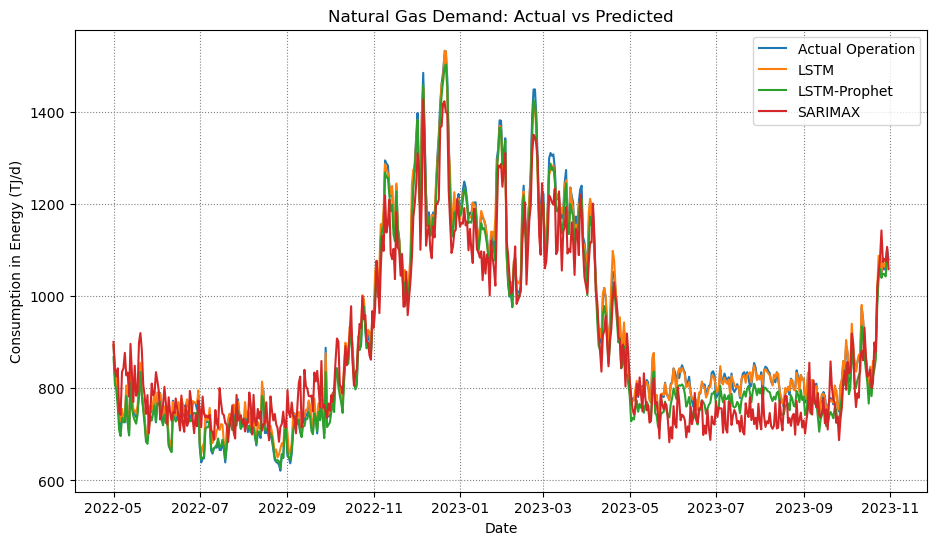

In [44]:
models_predictions_df['DATE'] = pd.to_datetime(models_predictions_df['DATE'])

# Plot the actual and predicted values
plt.figure(figsize=(11, 6))
plt.plot(models_predictions_df['DATE'], models_predictions_df['NG_DEMAND'], label='Actual Operation')
#plt.plot(models_predictions_df['DATE'], models_predictions_df['Baseline'], label='Baseline Model')
#plt.plot(models_predictions_df['DATE'], models_predictions_df['Prophet'], label='Prophet')
plt.plot(models_predictions_df['DATE'], models_predictions_df['LSTM'], label='LSTM')
plt.plot(models_predictions_df['DATE'], models_predictions_df['LSTM-Prophet'], label='LSTM-Prophet')
plt.plot(models_predictions_df['DATE'], models_predictions_df['SARIMAX'], label='SARIMAX')
#plt.plot(models_predictions_df['DATE'], models_predictions_df['LightGBM'], label='LightGBM')

plt.title('Natural Gas Demand: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Consumption in Energy (TJ/d)')
plt.grid(linestyle=":", color='grey')
plt.legend()
plt.show()

# Conclusion

Here is the updated comprehensive summary of the results:

- **Baseline Model**: This model has the highest Mean Squared Error (MSE) of 14638.16 and Root Mean Squared Error (RMSE) of 120.99, indicating that the predictions are, on average, quite far from the actual values. The Mean Absolute Percentage Error (MAPE) and Mean Absolute Error (MAE) are 12.21% and 109.18 respectively, suggesting that the model's predictions are off by around 12% on average. The Median Absolute Percentage Error (MDAPE) is 11.19%. The R-squared value is 0.65, which means that 65% of the variance in the dependent variable is predictable from the independent variable(s).

- **Prophet Model**: This model has significantly lower MSE (4337.65) and RMSE (65.86) compared to the Baseline model, indicating better performance. The MAPE is not available (NaN), but the MAE is 53.10. The MDAPE is also not available (NaN). The R-squared value is 0.90, suggesting that 90% of the variance in the dependent variable is predictable from the independent variable(s).

- **LSTM Model**: This model shows further improvement with an MSE of 1855.09 and RMSE of 43.07. The MAPE and MAE are 3.41% and 31.36 respectively, indicating that the model's predictions are off by around 3% on average. The MDAPE is 2.52%. The R-squared value is 0.96, meaning that 96% of the variance in the dependent variable is predictable from the independent variable(s).

- **LSTM-Prophet Model**: This model performs the best among all with the lowest MSE (653.94) and RMSE (25.57). The MAPE and MAE are 2.49% and 21.89 respectively, suggesting that the model's predictions are off by around 2% on average. The MDAPE is 2.10%. The R-squared value is 0.98, indicating that 98% of the variance in the dependent variable is predictable from the independent variable(s).

- **SARIMAX Model**: This model has an MSE of 4260.00 and RMSE of 65.20. The MAPE and MAE are 6.11% and 54.00 respectively, indicating that the model's predictions are off by around 6% on average. The MDAPE is 5.33%. The R-squared value is 0.90, suggesting that 90% of the variance in the dependent variable is predictable from the independent variable(s).

- **LightGBM Model**: This model has an MSE of 14269.28 and RMSE of 119.45. The MAPE and MAE are 12.13% and 108.22 respectively, suggesting that the model's predictions are off by around 12% on average. The MDAPE is 11.48%. The R-squared value is 0.66, which means that 66% of the variance in the dependent variable is predictable from the independent variable(s).

In summary, the LSTM-Prophet model performs the best in terms of prediction accuracy, followed by the LSTM model, the SARIMAX model, the Prophet model, the LightGBM model, and lastly the Baseline model.eline model.mentation.